# Twitter Sentiment Analysis using NLP & Machine Learning
### By: Nikhil Dange Patil
---
This project analyzes the sentiment (positive/negative) of tweets using:
- Sentiment140 dataset
- Text preprocessing
- TF-IDF vectorization
- Machine learning models (Naive Bayes, SVM, Logistic Regression)

Goal: Build a model that can classify any tweet into positive or negative sentiment.


In [3]:
%pip install kagglehub wordcloud scikit-learn pandas matplotlib

import kagglehub
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

from wordcloud import WordCloud
from collections import Counter


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Download Sentiment140 Dataset
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Dataset Path:", path)

# Main file
file_path = path + "/training.1600000.processed.noemoticon.csv"

# Column names (dataset has no header)
col_names = ["sentiment", "id", "date", "query", "user", "tweet"]
df = pd.read_csv(file_path, encoding="latin-1", names=col_names)

print("Shape of original dataset:", df.shape)
df.head()


Dataset Path: C:\Users\hp\.cache\kagglehub\datasets\kazanova\sentiment140\versions\2
Shape of original dataset: (1600000, 6)


,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df = df[["tweet", "sentiment"]]

# Convert sentiment 4 → 1
df["sentiment"] = df["sentiment"].replace({4: 1})

df.head()


,tweet,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [6]:
df = df.sample(n=100000, random_state=42)
print("Sampled shape:", df.shape)

df["sentiment"].value_counts()


Sampled shape: (100000, 2)


sentiment
1    50057
0    49943
Name: count, dtype: int64

In [7]:
print("Dataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDuplicate Rows:", df.duplicated().sum())

print("\nSample Tweets:")
df.head(10)

print("\nSentiment Value Counts:")
df["sentiment"].value_counts()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 541200 to 429504
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   tweet      100000 non-null  object
 1   sentiment  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB
None

Missing Values:
tweet        0
sentiment    0
dtype: int64

Duplicate Rows: 275

Sample Tweets:

Sentiment Value Counts:


sentiment
1    50057
0    49943
Name: count, dtype: int64

In [8]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["cleaned_tweet"] = df["tweet"].apply(clean_text)
df.head()


,tweet,sentiment,cleaned_tweet
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,0,ahhh i hope your ok
750,"@misstoriblack cool , i have no tweet apps fo...",0,cool i have no tweet apps for my razr
766711,@TiannaChaos i know just family drama. its la...,0,i know just family drama its lamehey next time...
285055,School email won't open and I have geography ...,0,school email wont open and i have geography st...
705995,upper airways problem,0,upper airways problem



Tweet Length Stats:
count    100000.00000
mean         62.14591
std          34.02147
min           0.00000
25%          34.00000
50%          57.00000
75%          89.00000
max         269.00000
Name: tweet_length, dtype: float64


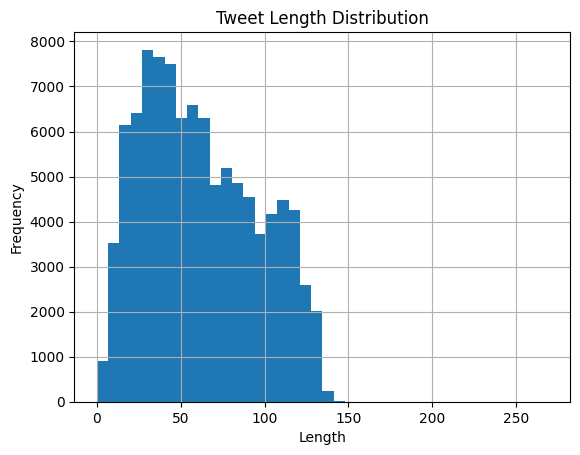

In [9]:
df["tweet_length"] = df["cleaned_tweet"].str.len()

print("\nTweet Length Stats:")
print(df["tweet_length"].describe())

# Histogram
df["tweet_length"].hist(bins=40)
plt.title("Tweet Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [10]:
all_words = " ".join(df["cleaned_tweet"]).split()
Counter(all_words).most_common(20)


[('i', 47283),
 ('to', 34952),
 ('the', 32395),
 ('a', 23828),
 ('my', 19615),
 ('and', 18581),
 ('you', 16977),
 ('is', 14765),
 ('it', 14557),
 ('for', 13586),
 ('in', 13513),
 ('of', 11310),
 ('im', 11080),
 ('on', 10420),
 ('me', 10004),
 ('so', 9421),
 ('have', 9214),
 ('that', 8899),
 ('but', 7968),
 ('just', 7860)]

In [11]:
pos = " ".join(df[df.sentiment==1]["cleaned_tweet"]).split()
neg = " ".join(df[df.sentiment==0]["cleaned_tweet"]).split()

print("\nMost Common Positive Words:")
print(Counter(pos).most_common(20))

print("\nMost Common Negative Words:")
print(Counter(neg).most_common(20))



Most Common Positive Words:
[('i', 18175), ('the', 16360), ('to', 15533), ('a', 12456), ('you', 11126), ('and', 9232), ('my', 7787), ('for', 7407), ('it', 7133), ('is', 6782), ('in', 6321), ('of', 5643), ('on', 5188), ('im', 4697), ('me', 4390), ('that', 4318), ('have', 4058), ('with', 4036), ('so', 3998), ('just', 3908)]

Most Common Negative Words:
[('i', 29108), ('to', 19419), ('the', 16035), ('my', 11828), ('a', 11372), ('and', 9349), ('is', 7983), ('it', 7424), ('in', 7192), ('im', 6383), ('for', 6179), ('you', 5851), ('of', 5667), ('me', 5614), ('so', 5423), ('on', 5232), ('have', 5156), ('but', 5120), ('that', 4581), ('not', 4517)]


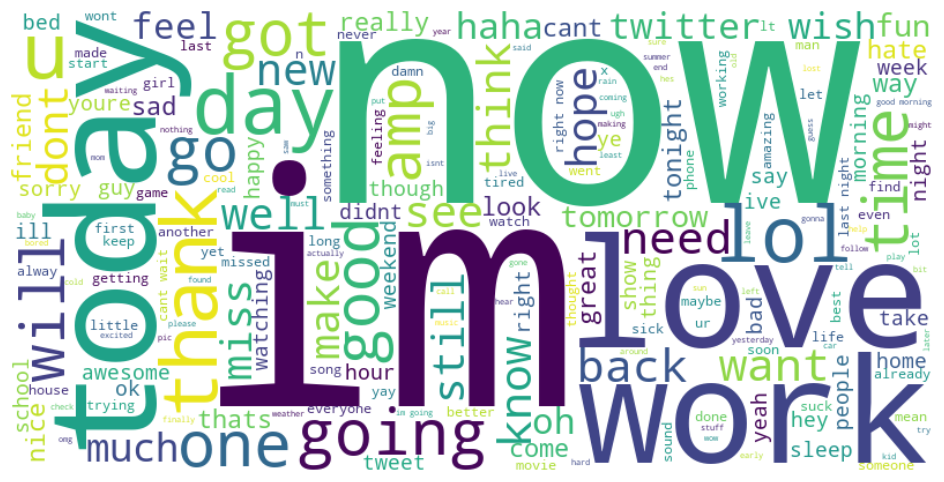

In [12]:
wc = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(df["cleaned_tweet"])
)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [13]:
X = df["cleaned_tweet"]
y = df["sentiment"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)


In [14]:
bnb = BernoulliNB()
svm = LinearSVC()
logreg = LogisticRegression(max_iter=300)

models = {
    "Bernoulli NB": bnb,
    "SVM": svm,
    "Logistic Regression": logreg
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Bernoulli NB Accuracy: 0.7612
SVM Accuracy: 0.7807
Logistic Regression Accuracy: 0.7855


In [15]:
for name, model in models.items():
    print("="*70)
    print(name)
    print(classification_report(y_test, model.predict(X_test)))


Bernoulli NB
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      9989
           1       0.75      0.79      0.77     10011

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

SVM
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      9989
           1       0.77      0.79      0.78     10011

    accuracy                           0.78     20000
   macro avg       0.78      0.78      0.78     20000
weighted avg       0.78      0.78      0.78     20000

Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      9989
           1       0.78      0.79      0.79     10011

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79    

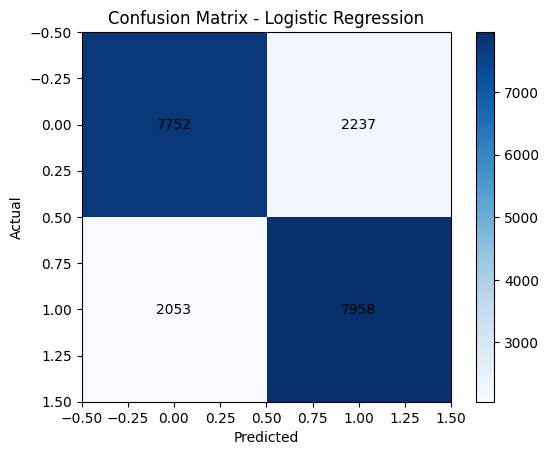

In [16]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

cm = confusion_matrix(y_test, best_model.predict(X_test))

plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [17]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = best_model.predict(vec)[0]
    return "Positive" if pred == 1 else "Negative"

samples = [
    "I love this product!",
    "This is the worst day ever.",
    "Not bad, could be better.",
    "Amazing experience!",
    "I hate everything."
]

for s in samples:
    print(s, "=>", predict_sentiment(s))


I love this product! => Positive
This is the worst day ever. => Negative
Not bad, could be better. => Positive
Amazing experience! => Positive
I hate everything. => Negative
